# Importing libraries

In [1]:
import keras #High level interface of TensorFlow
from keras.models import Sequential
from keras.layers import Activation
from keras.layers import InputLayer
from keras.layers.core import Dense,Flatten,Dropout
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.convolutional import *
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array, load_img

D:\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Image preprocessing

The paths to the particular data

In [12]:
train_path='../dataset/training_set'
test_path='../dataset/test_set'

In [13]:
batch_size = 16 #Every batch contains data from 16 different images 
#Data Augmentation
train_datagen = ImageDataGenerator( 
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)

train_set = train_datagen.flow_from_directory(
        train_path,
        target_size=(150, 150),  
        batch_size=batch_size,)  

test_set = test_datagen.flow_from_directory(
        test_path,
        target_size=(150, 150),
        batch_size=batch_size)

Found 1000 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


In [14]:
# plots images with labels within jupyter notebook
def plots(ims, figsize=(12,6), rows=1, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')

In [15]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

# Creating a model/Visualisation of the model

In [16]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(150, 150, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2))) #first block, frozen

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2))) #second block, frozen

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2))) #second block, frozen

model.add(Flatten()) #Stream data to "nodes" of the ANN
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5)) #Dropping out some data
model.add(Dense(2))
model.add(Activation('sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
activation_6 (Activation)    (None, 148, 148, 32)      0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 72, 72, 32)        9248      
_________________________________________________________________
activation_7 (Activation)    (None, 72, 72, 32)        0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 34, 34, 64)        18496     
__________

### Compiling the model.Setting particular algorithms up.

In [17]:
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

# Training the model.

In [ ]:
model.fit_generator(train_set,
                    steps_per_epoch = 1000//batch_size, #1000/16 numbers of batches per epoch
                    epochs = 50,
                    validation_data = test_set,
                    validation_steps = 200 //16) #same like above
                    

Saving the model for the future.

In [107]:
model.save_weights("dogs&cats_classifier.h5")

# Testing the model on a random sample/a group of sample photos.

Useful function.It converts an image to a set of arrays,which can be processed by the network.

In [87]:
def preprocess_img(img,target_size):
    img = img.resize(target_size)
    img = img_to_array(img)
    img = np.expand_dims(img,axis=0)
    return img

# A sample photo

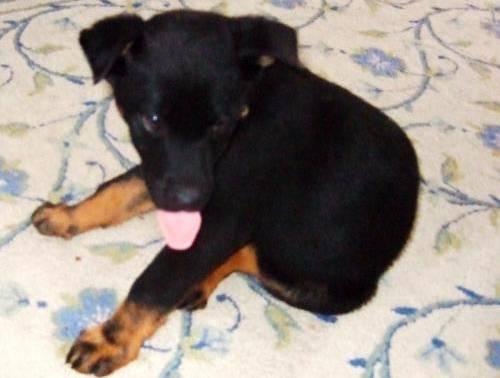

In [112]:
image = Image.open("test/dog.3983.jpg")
image

Preprocessing the image into a bunch of arrays.

In [110]:
preprocessed_image = preprocess_img(image,target_size=(150,150))

In [113]:
test_set.class_indices #If the output array is like: [0,1],we predict it's a dog, else if [1,0],that's a cat.

{'cats': 0, 'dogs': 1}

# Predicting the result

In [207]:
prediction = model.predict(preprocessed_image)
#Code below is a testing for a set (>1) prediction.
#test_batches = ImageDataGenerator(rescale=1. / 255).flow_from_directory("./test/",target_size=(150,150),batch_size=8)
# predictions = model.predict_generator(test_set, 200//16)
# print(predictions)

In [208]:
test_set = test_datagen.flow_from_directory(
        test_path,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode="binary")
test_imgs, test_labels = next(test_set)


Found 200 images belonging to 2 classes.


In [209]:
predictions = model.predict_generator(test_set,steps=1,verbose=0)

In [210]:
cm = confusion_matrix(test_labels,np.round(predictions[:,1]))

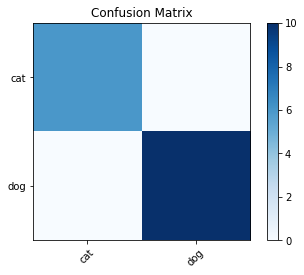

In [211]:
plot_confusion_matrix(cm,title="Confusion Matrix",classes=["cat","dog"])